# 8.6. Residual Networks (ResNet) and ResNeXt

À medida que projetamos redes cada vez mais profundas, torna-se imperativo entender como adicionar camadas pode aumentar a complexidade e a expressividade da rede. Para fazer algum progresso, precisamos de um pouco de matemática.

In [2]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

# 8.6.1. Classes de função

Assim, somente se classes de funções maiores contiverem as menores (funções aninhadas) é que garantimos que aumentá-las aumenta estritamente o poder expressivo da rede.

Como o novo modelo pode obter uma solução melhor para se ajustar ao conjunto de dados de treinamento, a camada adicionada pode facilitar a redução de erros de treinamento.

No cerne de sua rede residual proposta ( ResNet ) está a ideia de que cada camada adicional deve conter mais facilmente a função de identidade como um de seus elementos. Essas considerações são bastante profundas, mas levaram a uma solução surpreendentemente simples, um bloco residual . Com ele, o ResNet venceu o ImageNet Large Scale Visual Recognition Challenge em 2015. O design teve uma profunda influência em como construir redes neurais profundas. 



# 8.6.2. Blocos residuais

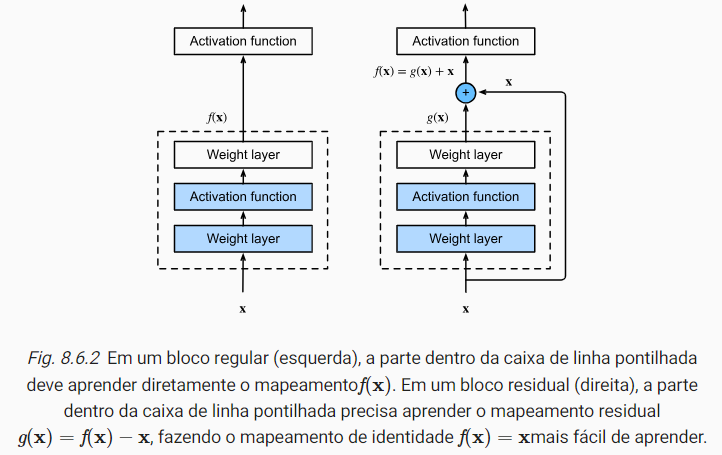

Na verdade, o bloco residual pode ser pensado como um caso especial do bloco Inception multi-branch: ele tem dois branches, um dos quais é o mapeamento de identidade.

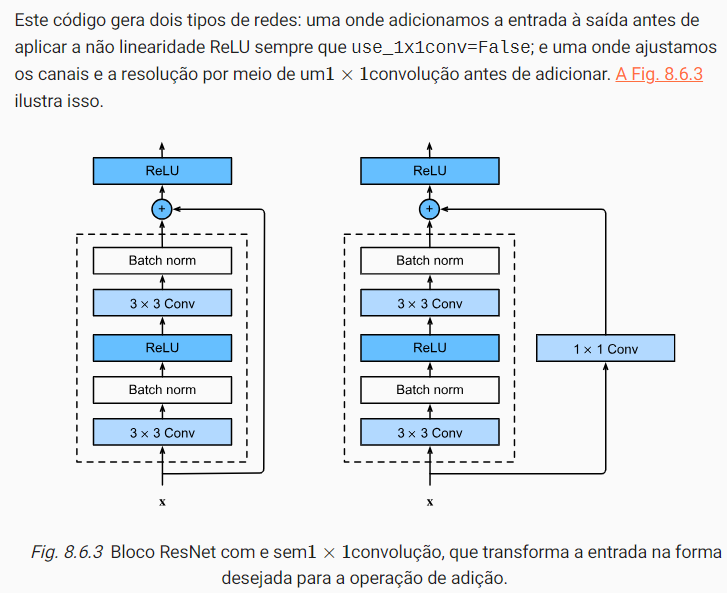

In [3]:
class Residual(nn.Module):  #@save                                          # A classe Residual pode ser substituída pela classe ResNeXt
    """The Residual block of ResNet models."""
    def __init__(self, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1,
                                   stride=strides)
        self.conv2 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.LazyConv2d(num_channels, kernel_size=1,
                                       stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.LazyBatchNorm2d()
        self.bn2 = nn.LazyBatchNorm2d()

    def forward(self, X):                       # arquitetura definida
        Y = F.relu(self.bn1(self.conv1(X)))     #  funções aninhadas
        Y = self.bn2(self.conv2(Y))             #  funções aninhadas
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

Agora vamos analisar uma situação em que a entrada e a saída têm o mesmo formato, onde a convolução 1x1 não é necessária.

In [4]:
blk = Residual(num_channels=3)                   # default:  use_1x1conv=False, strides=1
X = torch.randn(4, 3, 6, 6)
blk(X).shape

C:\Users\zeh\pythonProject\.venv\Lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


torch.Size([4, 3, 6, 6])

Também temos a opção de reduzir pela metade a altura e a largura da saída, aumentando o número de canais de saída. Neste caso, usamos 1x1 convoluções via __use_1x1conv=True__. Isso é útil no início de cada bloco ResNet para reduzir a dimensionalidade espacial via __strides=2__.

In [5]:
blk = Residual(num_channels=6, use_1x1conv=True, strides=2)       # reduz pela metade a altura e a largura da saída
blk(X).shape

torch.Size([4, 6, 3, 3])

# 8.6.3. Modelo ResNet

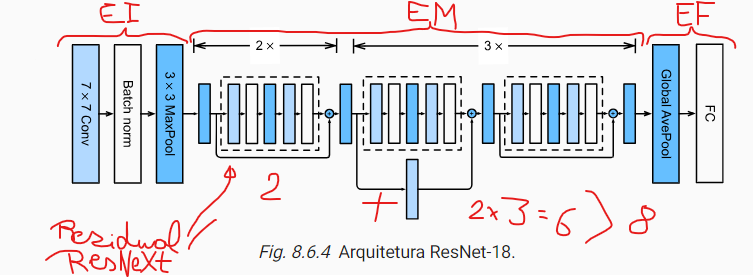

As duas primeiras camadas do ResNet são as mesmas do GoogLeNet ,
A diferença é a camada de normalização de lote adicionada após cada camada convolucional no ResNet.

In [6]:
# Etapa Inicial (EI): b1
class ResNet(d2l.Classifier):
    def b1(self):
        return nn.Sequential(
            nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
            nn.LazyBatchNorm2d(), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

- O GoogLeNet usa quatro módulos compostos de blocos Inception.
- O ResNet usa quatro módulos compostos de blocos residuais, cada um dos quais usa vários blocos residuais com o mesmo número de canais de saída.

O número de canais no primeiro módulo é o mesmo que o número de canais de entrada. Como uma camada de max-pooling com um stride de 2 já foi usada, não é necessário reduzir a altura e a largura.

No primeiro bloco residual para cada um dos módulos subsequentes, o número de canais é dobrado em comparação com o do módulo anterior, e a altura e a largura são reduzidas pela metade.

In [7]:
# Etapa Mediana (EM): block
@d2l.add_to_class(ResNet)
def block(self, num_residuals, num_channels, first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual(num_channels, use_1x1conv=True, strides=2))   # com 1x1 convolução e saída reduzida pela metade.
        else:
            blk.append(Residual(num_channels))                                # sem 1x1 convolução e saída igual a entrada.
    return nn.Sequential(*blk)

Então, adicionamos todos os módulos ao ResNet. Aqui, dois blocos residuais são usados para cada módulo. Por fim, assim como o GoogLeNet, adicionamos uma camada de pooling média global, seguida pela saída da camada totalmente conectada.

In [8]:
@d2l.add_to_class(ResNet)
def __init__(self, arch, lr=0.1, num_classes=10):
    super(ResNet, self).__init__()                      # inicializado com o bloco inicial (ResNet) igual ao GoogLeNet.
    self.save_hyperparameters()
    
    self.net = nn.Sequential(self.b1())                 # Etapa Inicial (EI): inicializado com o bloco inicial (ResNet) igual ao GoogLeNet.
    
    for i, b in enumerate(arch):
        self.net.add_module(f'b{i+2}', self.block(*b, first_block=(i==0)))  # Etapa Mediana (EM): blocos adicionados conforme a estrutura arch
    
    self.net.add_module('last', nn.Sequential(          # Etapa Final (EF)
        nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(),
        nn.LazyLinear(num_classes)))
    
    self.net.apply(d2l.init_cnn)                        # Aplica a inicialização Xavier.

Junto com a primeira 7x7 camada convolucional e a camada final totalmente conectada, há 18 camadas no total. Portanto, esse modelo é comumente conhecido como __ResNet-18__.


Ao configurar diferentes números de canais e blocos residuais no módulo, podemos criar diferentes modelos ResNet, como o ResNet-152 de 152 camadas mais profundo. 

Embora a arquitetura principal do ResNet seja semelhante à do GoogLeNet, a estrutura do ResNet é mais simples e fácil de modificar. Todos esses fatores resultaram no uso rápido e generalizado do ResNet.

Antes de treinar o ResNet, vamos observar como o formato de entrada muda em diferentes módulos no ResNet. Como em todas as arquiteturas anteriores, a resolução diminui enquanto o número de canais aumenta até o ponto em que uma camada de pooling média global agrega todos os recursos.

In [9]:
class ResNet18(ResNet):                              # ResNet18 é classe filha de ResNet
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__(((2, 64), (2, 128), (2, 256), (2, 512)),         # arch = ((2, 64), (2, 128), (2, 256), (2, 512))
                       lr, num_classes)

ResNet18().layer_summary((1, 1, 96, 96))

Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 128, 12, 12])
Sequential output shape:	 torch.Size([1, 256, 6, 6])
Sequential output shape:	 torch.Size([1, 512, 3, 3])
Sequential output shape:	 torch.Size([1, 10])


# 8.6.4. Treinamento

Treinamos o ResNet no conjunto de dados Fashion-MNIST, assim como antes. O ResNet é uma arquitetura bastante poderosa e flexível. O gráfico que captura a perda de treinamento e validação ilustra uma lacuna significativa entre ambos os gráficos, com a perda de treinamento sendo consideravelmente menor. Para uma rede com essa flexibilidade, mais dados de treinamento ofereceriam benefícios distintos para fechar a lacuna e melhorar a precisão.

In [ ]:
model = ResNet18(lr=0.01)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(96, 96))
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer.fit(model, data)

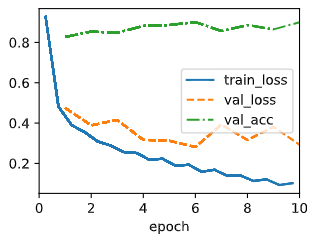

# Código Agrupado

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

# ----------------------------------------------------------------------------------------------

class Residual(nn.Module):  #@save
    """The Residual block of ResNet models."""
    def __init__(self, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1,
                                   stride=strides)
        self.conv2 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.LazyConv2d(num_channels, kernel_size=1,
                                       stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.LazyBatchNorm2d()
        self.bn2 = nn.LazyBatchNorm2d()

    def forward(self, X):                       # arquitetura definida
        Y = F.relu(self.bn1(self.conv1(X)))     #  funções aninhadas
        Y = self.bn2(self.conv2(Y))             #  funções aninhadas
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

# ----------------------------------------------------------------------------------------------

# Etapa Inicial (EI): b1
class ResNet(d2l.Classifier):
    def b1(self):
        return nn.Sequential(
            nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
            nn.LazyBatchNorm2d(), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

# ----------------------------------------------------------------------------------------------

# Etapa Mediana (EM): block
@d2l.add_to_class(ResNet)
def block(self, num_residuals, num_channels, first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual(num_channels, use_1x1conv=True, strides=2))   # com 1x1 convolução e saída reduzida pela metade.
        else:
            blk.append(Residual(num_channels))                                # sem 1x1 convolução e saída igual a entrada.
    return nn.Sequential(*blk)

# ----------------------------------------------------------------------------------------------

@d2l.add_to_class(ResNet)
def __init__(self, arch, lr=0.1, num_classes=10):
    super(ResNet, self).__init__()                      # inicializado com o bloco inicial (ResNet) igual ao GoogLeNet.
    self.save_hyperparameters()
    
    self.net = nn.Sequential(self.b1())                 # Etapa Inicial (EI): inicializado com o bloco inicial (ResNet) igual ao GoogLeNet.
    
    for i, b in enumerate(arch):
        self.net.add_module(f'b{i+2}', self.block(*b, first_block=(i==0)))  # Etapa Mediana (EM): blocos adicionados conforme a estrutura arch
    
    self.net.add_module('last', nn.Sequential(          # Etapa Final (EF)
        nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(),
        nn.LazyLinear(num_classes)))
    
    self.net.apply(d2l.init_cnn)                        # Aplica a inicialização Xavier.

# ----------------------------------------------------------------------------------------------

class ResNet18(ResNet):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__(((2, 64), (2, 128), (2, 256), (2, 512)),
                       lr, num_classes)

ResNet18().layer_summary((1, 1, 96, 96))

# ----------------------------------------------------------------------------------------------

model = ResNet18(lr=0.01)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(96, 96))
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer.fit(model, data)

# ------------------------------------------------------------------------------------
# PEGAR y_hat e imprimir acc:
# ------------------------------------------------------------------------------------
X,y = next(iter(data.get_dataloader(False)))
X = X.to('cuda')
y = y.to('cuda')
y_hat = model(X)
model.accuracy(y_hat,y).item()

https://colab.research.google.com/drive/1Z3A13OxTz2A0x93wERzIusR9g4kC9tlu#scrollTo=jutUiNec6hxG

----------------------------
--------------------------

# 8.6.5. ResNeXt

Um dos desafios que se encontra no design do ResNet é o trade-off entre não linearidade e dimensionalidade dentro de um determinado bloco. Ou seja, poderíamos adicionar mais não linearidade aumentando o número de camadas ou aumentando a largura das convoluções. Uma estratégia alternativa é aumentar o número de canais que podem transportar informações entre blocos.  Infelizmente, o último vem com uma penalidade quadrática.

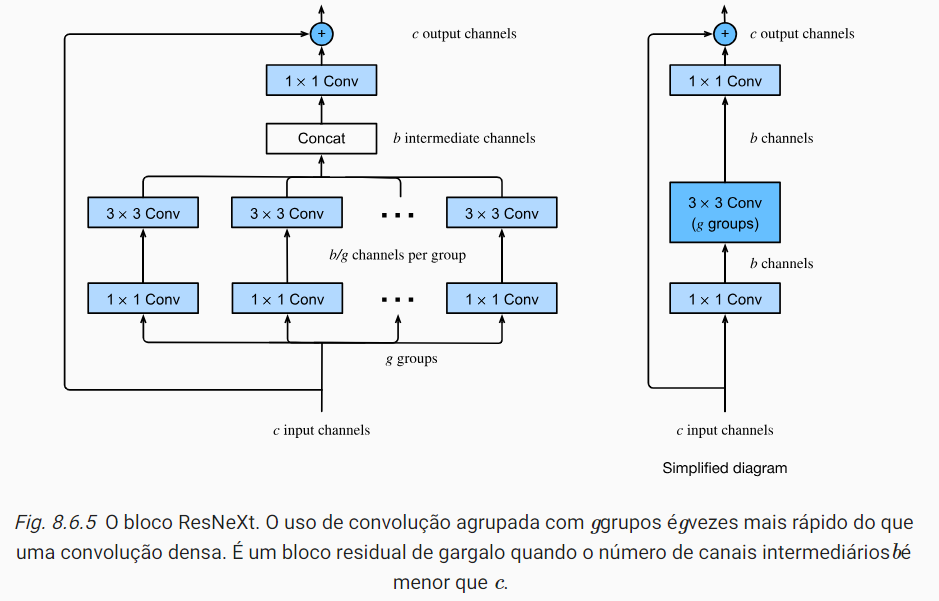



O custo computacional de O((ci*co)/g), ou seja, é g vezes mais rápido.

In [10]:
class ResNeXtBlock(nn.Module):  #@save
    """The ResNeXt block."""
    def __init__(self, num_channels, groups, bot_mul, use_1x1conv=False,
                 strides=1):
        super().__init__()
        bot_channels = int(round(num_channels * bot_mul))
        self.conv1 = nn.LazyConv2d(bot_channels, kernel_size=1, stride=1)
        self.conv2 = nn.LazyConv2d(bot_channels, kernel_size=3,
                                   stride=strides, padding=1,
                                   groups=bot_channels//groups)
        self.conv3 = nn.LazyConv2d(num_channels, kernel_size=1, stride=1)
        self.bn1 = nn.LazyBatchNorm2d()
        self.bn2 = nn.LazyBatchNorm2d()
        self.bn3 = nn.LazyBatchNorm2d()
        if use_1x1conv:
            self.conv4 = nn.LazyConv2d(num_channels, kernel_size=1,
                                       stride=strides)
            self.bn4 = nn.LazyBatchNorm2d()
        else:
            self.conv4 = None

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = F.relu(self.bn2(self.conv2(Y)))
        Y = self.bn3(self.conv3(Y))
        if self.conv4:
            X = self.bn4(self.conv4(X))
        return F.relu(Y + X)

Seu uso é inteiramente análogo ao ResNetBlockdiscutido anteriormente. Por exemplo, ao usar (use_1x1conv=False, strides=1), a entrada e a saída têm o mesmo formato. Alternativamente, definir metades da altura e largura da saída: (use_1x1conv=False, strides=1use_1x1conv=True, strides=2).

In [11]:
blk = ResNeXtBlock(num_channels=32, groups=16, bot_mul=1)
X = torch.randn(4, 32, 96, 96)
blk(X).shape

torch.Size([4, 32, 96, 96])

# Código Agrupado - ResNeXt

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

# ------------------------------------------------------------------------------------

class ResNeXtBlock(nn.Module):  #@save                                                 # Substitui a classe Residual
    """The ResNeXt block."""
    def __init__(self, num_channels=32, groups=16, bot_mul=1, use_1x1conv=False,
                 strides=1):    # ResNeXtBlock(num_channels=32, groups=16, bot_mul=1)
        super().__init__()
        bot_channels = int(round(num_channels * bot_mul))
        self.conv1 = nn.LazyConv2d(bot_channels, kernel_size=1, stride=1)
        self.conv2 = nn.LazyConv2d(bot_channels, kernel_size=3,
                                   stride=strides, padding=1,
                                   groups=bot_channels//groups)
        self.conv3 = nn.LazyConv2d(num_channels, kernel_size=1, stride=1)
        self.bn1 = nn.LazyBatchNorm2d()
        self.bn2 = nn.LazyBatchNorm2d()
        self.bn3 = nn.LazyBatchNorm2d()
        if use_1x1conv:
            self.conv4 = nn.LazyConv2d(num_channels, kernel_size=1,
                                       stride=strides)
            self.bn4 = nn.LazyBatchNorm2d()
        else:
            self.conv4 = None

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = F.relu(self.bn2(self.conv2(Y)))
        Y = self.bn3(self.conv3(Y))
        if self.conv4:
            X = self.bn4(self.conv4(X))
        return F.relu(Y + X)

# ------------------------------------------------------------------------------------

# Etapa Inicial (EI): b1
class ResNet(d2l.Classifier):
    def b1(self):
        return nn.Sequential(
            nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
            nn.LazyBatchNorm2d(), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
       
# ------------------------------------------------------------------------------------

@d2l.add_to_class(ResNet)
def block(self, num_residuals, num_channels, first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(ResNeXtBlock(num_channels, use_1x1conv=True, strides=2))   # mudei de Residual para ResNeXtBlock
        else:
            blk.append(ResNeXtBlock(num_channels))                                # mudei de Residual para ResNeXtBlock
    return nn.Sequential(*blk)

# ------------------------------------------------------------------------------------

@d2l.add_to_class(ResNet)
def __init__(self, arch, lr=0.1, num_classes=10):
    super(ResNet, self).__init__()                      # inicializado com o bloco inicial (ResNet) igual ao GoogLeNet.
    self.save_hyperparameters()
    
    self.net = nn.Sequential(self.b1())                 # Etapa Inicial (EI): inicializado com o bloco inicial (ResNet) igual ao GoogLeNet.
    
    for i, b in enumerate(arch):
        self.net.add_module(f'b{i+2}', self.block(*b, first_block=(i==0)))  # Etapa Mediana (EM): blocos adicionados conforme a estrutura arch
    
    self.net.add_module('last', nn.Sequential(          # Etapa Final (EF)
        nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(),
        nn.LazyLinear(num_classes)))
    
    self.net.apply(d2l.init_cnn)                        # Aplica a inicialização Xavier.

# ------------------------------------------------------------------------------------

class ResNet18(ResNet):                              # ResNet18 é classe filha de ResNet
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__(((2, 64), (2, 128), (2, 256), (2, 512)),         # arch = ((2, 64), (2, 128), (2, 256), (2, 512))
                       lr, num_classes)

# ------------------------------------------------------------------------------------

#ResNeXtBlock(num_channels=32, groups=16, bot_mul=1)
model = ResNet18(lr=0.01)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(96, 96))
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer.fit(model, data)

# ------------------------------------------------------------------------------------
# PEGAR y_hat e imprimir acc:
# ------------------------------------------------------------------------------------
X,y = next(iter(data.get_dataloader(False)))
X = X.to('cuda')
y = y.to('cuda')
y_hat = model(X)
model.accuracy(y_hat,y).item()

https://colab.research.google.com/drive/1Z3A13OxTz2A0x93wERzIusR9g4kC9tlu#scrollTo=jutUiNec6hxG

# 8.6.6. Resumo e Discussão

Classes de função aninhadas são desejáveis, pois nos permitem obter classes de função estritamente mais poderosas, em vez de também sutilmente diferentes, ao adicionar capacidade. Uma maneira de fazer isso é deixar camadas adicionais simplesmente passarem da entrada para a saída. Conexões residuais permitem isso. Como consequência, isso muda o viés indutivo de funções simples sendo da forma f(x)=0 para funções simples que parecem f(x)=x.

O ResNeXt é um exemplo de como o design de redes neurais convolucionais evoluiu ao longo do tempo: ao ser mais econômico com a computação e negociá-la em relação ao tamanho das ativações (número de canais), ele permite redes mais rápidas e precisas a um custo menor.

Uma característica comum dos designs que discutimos até agora é que o design da rede é bastante manual, contando principalmente com a engenhosidade do designer para encontrar os hiperparâmetros de rede “certos”. Embora claramente viável, também é muito custoso em termos de tempo humano e não há garantia de que o resultado seja ótimo em qualquer sentido. Na Seção 8.8, discutiremos uma série de estratégias para obter redes de alta qualidade de forma mais automatizada.

# 8.6.7. Exercícios

# Ex. 1 - Quais são as principais diferenças entre o bloco Inception na Fig. 8.4.1 e o bloco residual? Como eles se comparam em termos de computação, precisão e classes de funções que podem descrever?

In summary, the major difference between the Inception block and the residual block lies in their architectural goals and design principles. The Inception block focuses on capturing features at different scales using parallel operations, while the residual block focuses on enabling the training of very deep networks by introducing skip connections that facilitate the learning of residual transformations. Both architectural components have been instrumental in advancing the capabilities of deep neural networks for various tasks.

# Ex. 2 - Consulte a Tabela 1 no artigo ResNet ( He et al. , 2016 ) para implementar diferentes variantes da rede.

- ResNet34

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l


class ResNeXtBlock(nn.Module):  #@save                                                 # Substitui a classe Residual
    """The ResNeXt block."""
    def __init__(self, num_channels=32, groups=16, bot_mul=1, use_1x1conv=False,
                 strides=1):    # ResNeXtBlock(num_channels=32, groups=16, bot_mul=1)
        super().__init__()
        bot_channels = int(round(num_channels * bot_mul))
        self.conv1 = nn.LazyConv2d(bot_channels, kernel_size=1, stride=1)
        self.conv2 = nn.LazyConv2d(bot_channels, kernel_size=3,
                                   stride=strides, padding=1,
                                   groups=bot_channels//groups)
        self.conv3 = nn.LazyConv2d(num_channels, kernel_size=1, stride=1)
        self.bn1 = nn.LazyBatchNorm2d()
        self.bn2 = nn.LazyBatchNorm2d()
        self.bn3 = nn.LazyBatchNorm2d()
        if use_1x1conv:
            self.conv4 = nn.LazyConv2d(num_channels, kernel_size=1,
                                       stride=strides)
            self.bn4 = nn.LazyBatchNorm2d()
        else:
            self.conv4 = None

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = F.relu(self.bn2(self.conv2(Y)))
        Y = self.bn3(self.conv3(Y))
        if self.conv4:
            X = self.bn4(self.conv4(X))
        return F.relu(Y + X)

# ------------------------------------------------------------------------------------

# ------------------------------------------------------------------------------------

# Etapa Inicial (EI): b1
class ResNet(d2l.Classifier):
    def b1(self):
        return nn.Sequential(
            nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
            nn.LazyBatchNorm2d(), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

        
# ------------------------------------------------------------------------------------

@d2l.add_to_class(ResNet)
def block(self, num_residuals, num_channels, first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(ResNeXtBlock(num_channels, use_1x1conv=True, strides=2))   # mudei de Residual para ResNeXtBlock
        else:
            blk.append(ResNeXtBlock(num_channels))                                # mudei de Residual para ResNeXtBlock
    return nn.Sequential(*blk)

# ------------------------------------------------------------------------------------

@d2l.add_to_class(ResNet)
def __init__(self, arch, lr=0.1, num_classes=10):
    super(ResNet, self).__init__()                      # inicializado com o bloco inicial (ResNet) igual ao GoogLeNet.
    self.save_hyperparameters()
    
    self.net = nn.Sequential(self.b1())                 # Etapa Inicial (EI): inicializado com o bloco inicial (ResNet) igual ao GoogLeNet.
    
    for i, b in enumerate(arch):
        self.net.add_module(f'b{i+2}', self.block(*b, first_block=(i==0)))  # Etapa Mediana (EM): blocos adicionados conforme a estrutura arch
    
    self.net.add_module('last', nn.Sequential(          # Etapa Final (EF)
        nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(),
        nn.LazyLinear(num_classes)))
    
    self.net.apply(d2l.init_cnn)                        # Aplica a inicialização Xavier.

# ------------------------------------------------------------------------------------

class ResNet34(ResNet):                              # ResNet18 é classe filha de ResNet
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__(((3, 64), (4, 128), (6, 256), (3, 512)),         # arch = ((2, 64), (2, 128), (2, 256), (2, 512))
                       lr, num_classes)

# ------------------------------------------------------------------------------------

#ResNeXtBlock(num_channels=32, groups=16, bot_mul=1)
model = ResNet34(lr=0.01)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(96, 96))
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer.fit(model, data)

# ------------------------------------------------------------------------------------
# PEGAR y_hat e imprimir acc:
# ------------------------------------------------------------------------------------
X,y = next(iter(data.get_dataloader(False)))
X = X.to('cuda')
y = y.to('cuda')
y_hat = model(X)
model.accuracy(y_hat,y).item()

https://colab.research.google.com/drive/15ul6pI15_Tb-2nbfW3hc7BO8VwWQ5YcC#scrollTo=beyxwdbHx61I

# Ex. 3 - Para redes mais profundas, o ResNet introduz uma arquitetura de “gargalo” (bottleneck) para reduzir a complexidade do modelo. Tente implementá-la.

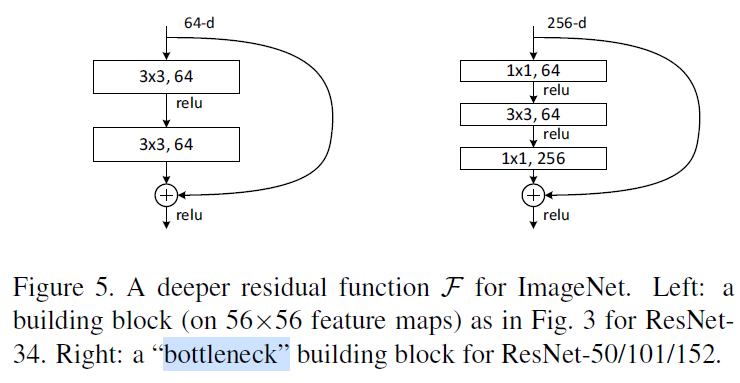

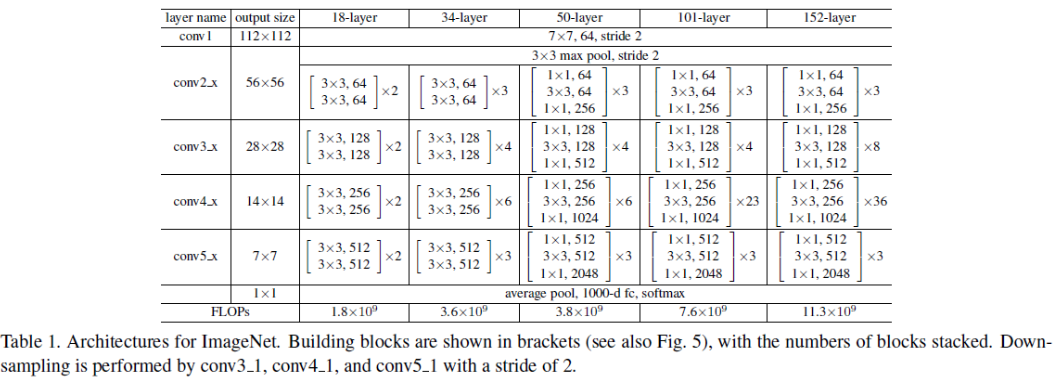


In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l
import torchvision

# ----------------------------------------------------------------------------------------------

class Residual(nn.Module):  # @save                                                   # Bottleneck
    """The Residual block of ResNet models."""

    def __init__(self, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        # self.conv1 = nn.LazyConv2d(num_channels, kernel_size=1, padding=0, stride=strides)
        # self.conv2 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1, stride=strides)
        # self.conv3 = nn.LazyConv2d(num_channels * 4, kernel_size=1, padding=0, stride=strides)

        # self.conv1 = nn.LazyConv2d(num_channels, kernel_size=1, stride=strides)
        # self.conv2 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1, stride=strides)
        # self.conv3 = nn.LazyConv2d(num_channels * 4, kernel_size=1, stride=strides)

        # self.conv1 = nn.LazyConv2d(num_channels, kernel_size=1)
        # self.conv2 = nn.LazyConv2d(num_channels, kernel_size=3, padding=0)
        # self.conv3 = nn.LazyConv2d(num_channels * 4, kernel_size=1, stride=3)

        self.conv1 = nn.LazyConv2d(num_channels, kernel_size=1)
        self.conv2 = nn.LazyConv2d(num_channels, kernel_size=3, stride=strides, padding=1)
        self.conv3 = nn.LazyConv2d(num_channels * 4, kernel_size=1)

        if use_1x1conv:
            self.conv4 = nn.LazyConv2d(num_channels * 4, kernel_size=1, stride=strides)
        else:
            self.conv4 = None
        self.bn1 = nn.LazyBatchNorm2d()
        self.bn2 = nn.LazyBatchNorm2d()
        self.bn3 = nn.LazyBatchNorm2d()

    def forward(self, X):  # arquitetura definida
        Y = F.relu(self.bn1(self.conv1(X)))  # funções aninhadas
        Y = F.relu(self.bn2(self.conv2(Y)))  # funções aninhadas
        Y = self.bn3(self.conv3(Y))  # funções aninhadas

        if self.conv4:
            X = self.conv4(X)

        Y += X
        return F.relu(Y)


# ----------------------------------------------------------------------------------------------

# Etapa Inicial (EI): b1
class ResNet(d2l.Classifier):
    def b1(self):
        return nn.Sequential(
            nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
            nn.LazyBatchNorm2d(), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))


# ----------------------------------------------------------------------------------------------

# Etapa Mediana (EM): block
@d2l.add_to_class(ResNet)
def block(self, num_residuals, num_channels, first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(
                Residual(num_channels, use_1x1conv=True, strides=2))  # com 1x1 convolução e saída reduzida pela metade.
        else:
            blk.append(Residual(num_channels, strides=2))  # sem 1x1 convolução e saída igual a entrada.
            # blk.append(Residual(num_channels))  # sem 1x1 convolução e saída igual a entrada.

    return nn.Sequential(*blk)


# ----------------------------------------------------------------------------------------------

@d2l.add_to_class(ResNet)
def __init__(self, arch, lr=0.1, num_classes=10):
    super(ResNet, self).__init__()  # inicializado com o bloco inicial (ResNet) igual ao GoogLeNet.
    self.save_hyperparameters()

    self.net = nn.Sequential(
        self.b1())  # Etapa Inicial (EI): inicializado com o bloco inicial (ResNet) igual ao GoogLeNet.

    for i, b in enumerate(arch):
        self.net.add_module(f'b{i + 2}', self.block(*b, first_block=(
                    i == 0)))  # Etapa Mediana (EM): blocos adicionados conforme a estrutura arch

    self.net.add_module('last', nn.Sequential(  # Etapa Final (EF)
        nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(),
        nn.LazyLinear(num_classes)))

    self.net.apply(d2l.init_cnn)  # Aplica a inicialização Xavier.


# ----------------------------------------------------------------------------------------------

class ResNet50(ResNet):
    def __init__(self, lr=0.1, num_classes=10):
        # super().__init__(((2, 64), (2, 128), (2, 256), (2, 512)),
        #                lr, num_classes)
        super().__init__(((3, 64), (4, 128), (6, 256), (3, 512)),
                         lr, num_classes)


ResNet50().layer_summary((1, 1, 224, 224))

# ----------------------------------------------------------------------------------------------
# model = torchvision.models.resnet50()

C:\Users\zeh\pythonProject\.venv\Lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Sequential output shape:	 torch.Size([1, 64, 56, 56])


RuntimeError: The size of tensor a (28) must match the size of tensor b (56) at non-singleton dimension 3

# Ex. 4 - Em versões subsequentes do ResNet, os autores mudaram a estrutura de “convolução, normalização de lote e ativação” para a estrutura de “normalização de lote, ativação e convolução”. Faça você mesmo essa melhoria. Veja a Figura 1 em He et al. ( 2016 ) para detalhes.

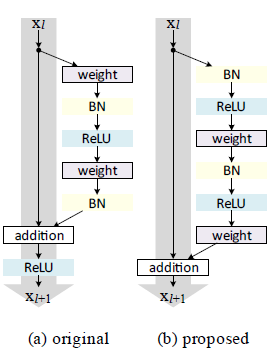

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

# ----------------------------------------------------------------------------------------------

class Residual(nn.Module):  #@save
    """The Residual block of ResNet models."""
    def __init__(self, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1)
        
        if use_1x1conv:
            self.conv3 = nn.LazyConv2d(num_channels, kernel_size=1, stride=strides)
        else:
            self.conv3 = None
            
        self.bn1 = nn.LazyBatchNorm2d()
        self.bn2 = nn.LazyBatchNorm2d()

    def forward(self, X):                       # arquitetura definida
        Y = self.conv1(F.relu(self.bn1(X)))     #  funções aninhadas
        Y = self.conv2(F.relu(self.bn2(Y)))             #  funções aninhadas
        
        if self.conv3:
            X = self.conv3(X)
        
        Y += X
        
        return F.relu(Y)





# ----------------------------------------------------------------------------------------------

# Etapa Inicial (EI): b1
class ResNet(d2l.Classifier):
    def b1(self):
        return nn.Sequential(
            nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
            nn.LazyBatchNorm2d(), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

# ----------------------------------------------------------------------------------------------

# Etapa Mediana (EM): block
@d2l.add_to_class(ResNet)
def block(self, num_residuals, num_channels, first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual(num_channels, use_1x1conv=True, strides=2))   # com 1x1 convolução e saída reduzida pela metade.
        else:
            blk.append(Residual(num_channels))                                # sem 1x1 convolução e saída igual a entrada.
    return nn.Sequential(*blk)

# ----------------------------------------------------------------------------------------------

@d2l.add_to_class(ResNet)
def __init__(self, arch, lr=0.1, num_classes=10):
    super(ResNet, self).__init__()                      # inicializado com o bloco inicial (ResNet) igual ao GoogLeNet.
    self.save_hyperparameters()
    
    self.net = nn.Sequential(self.b1())                 # Etapa Inicial (EI): inicializado com o bloco inicial (ResNet) igual ao GoogLeNet.
    
    for i, b in enumerate(arch):
        self.net.add_module(f'b{i+2}', self.block(*b, first_block=(i==0)))  # Etapa Mediana (EM): blocos adicionados conforme a estrutura arch
    
    self.net.add_module('last', nn.Sequential(          # Etapa Final (EF)
        nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(),
        nn.LazyLinear(num_classes)))
    
    self.net.apply(d2l.init_cnn)                        # Aplica a inicialização Xavier.

# ----------------------------------------------------------------------------------------------

class ResNet18(ResNet):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__(((2, 64), (2, 128), (2, 256), (2, 512)),
                       lr, num_classes)

ResNet18().layer_summary((1, 1, 96, 96))

# ----------------------------------------------------------------------------------------------

model = ResNet18(lr=0.01)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(96, 96))
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer.fit(model, data)

# ------------------------------------------------------------------------------------
# PEGAR y_hat e imprimir acc:
# ------------------------------------------------------------------------------------
X,y = next(iter(data.get_dataloader(False)))
X = X.to('cuda')
y = y.to('cuda')
y_hat = model(X)
model.accuracy(y_hat,y).item()

Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 128, 12, 12])
Sequential output shape:	 torch.Size([1, 256, 6, 6])
Sequential output shape:	 torch.Size([1, 512, 3, 3])
Sequential output shape:	 torch.Size([1, 10])


# Outras respostas:

https://pandalab.me/archives/resnet

# Referências

https://towardsdatascience.com/creating-deeper-bottleneck-resnet-from-scratch-using-tensorflow-93e11ff7eb02